# 3. CONDITIONAL GENERATIVE ADVERSARIAL NETWORKS

**[+1 extra point]** Create your own Conditional Generative Adversarial Network to generate conditioned samples in the `Fashion MNIST` dataset.

You can follow the notebook 03_cdcgan_fashion_mnist_template.ipynb.

This blog might be of a great help here: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarialnetwork-from-scratch/

Note that in this blog the discriminator uses a sigmoid as the final activation function. Do not use this if you are working with cross_entropy with `logits=true`. If you do, you will apply sigmoid twice… and it will never converge.

The final gif created after 100 epochs using a seed of 100 random samples with labels from 0 to 9 should be similar to the one attached `02_cdcgan_fashion_mnist.gif`. Note that every column represents the same class.

##### Some parts are copyright 2019 The TensorFlow Authors.

# Deep Conditional Convolutional Generative Adversarial Network

Import required libraries.

In [1]:
# To generate GIFs
!pip install -q imageio

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt

import os
import PIL
import time

from IPython import display

In [4]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

from tensorflow.keras import layers

from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

Set random seed, to have reproducible results

In [5]:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed?hl=d
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# Set seed

tf.random.set_seed(1234)
np.random.seed(1234)

### Load and prepare the dataset

You will use the `Fashion MNIST` dataset to train the generator and the discriminator. Later, the `generator` will generate fashion elements resembling the original data.

In [6]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [7]:
tfds.list_builders()
builder = tfds.builder("fashion_mnist")
builder.download_and_prepare()

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOG832M/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOG832M/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
print(builder.info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

Creating the training set.

In [9]:
(train_dataset_raw) = builder.as_dataset(split="train", as_supervised=True)

The cell values are scaled to decimal, following [-1 to 1].

Also, the images are being resized to 28x28 pixels.

In [10]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  # scale from [0,255] to [-1,1]
  image = (image - 127.5) / 127.5
  image = tf.image.resize(image, (28, 28))
  return image, label

In [11]:
# Apply of the function `format_example` to the original training dataset.
train_dataset = train_dataset_raw.map(format_example)

Plot of the first 49 objects/items in the training dataset.

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype

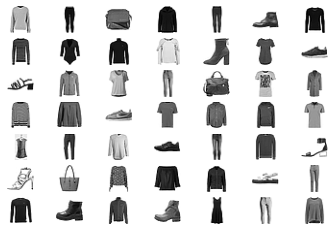

In [12]:
i = 0
for image, label in train_dataset.take(49):
  # define subplot
  plt.subplot(7, 7, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = (image + 1.0) / 2.0
  plt.imshow(image[:,:,0], cmap='gray_r')
  i = i + 1
  print(label)
plt.show()

## Create the models

Both the generator and discriminator are not being defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses `tanh`.

In this case, you can see the 100-element point in latent space (see variable `latent_dim`) as input and subsequent resizing (left) and the new class label input and embedding layer (right), then the concatenation of the two sets of feature maps (center). The remainder of the model is the same as the unconditional case. 

The number of available classes is passed in the variable `n_class`.

In [13]:
# make your own generator model
def make_generator_model(n_classes, latent_dim=100):
  
  # Right side at the following plot
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input.
  # Turns positive integers (indexes) into dense vectors of fixed size, again for a categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)

  # Left side at the following plot
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image. Scalling up
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  # Activation function
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)

  # Merged path at the center
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  # The last layer activation function is `tanh`
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = Model([in_lat, in_label], out_layer)
  
  return model

The size of the generator output is a picture of 28x28 pixels and 1 channel. But is based on the right path that defines the label.

Use the (as yet untrained) generator to create an image.

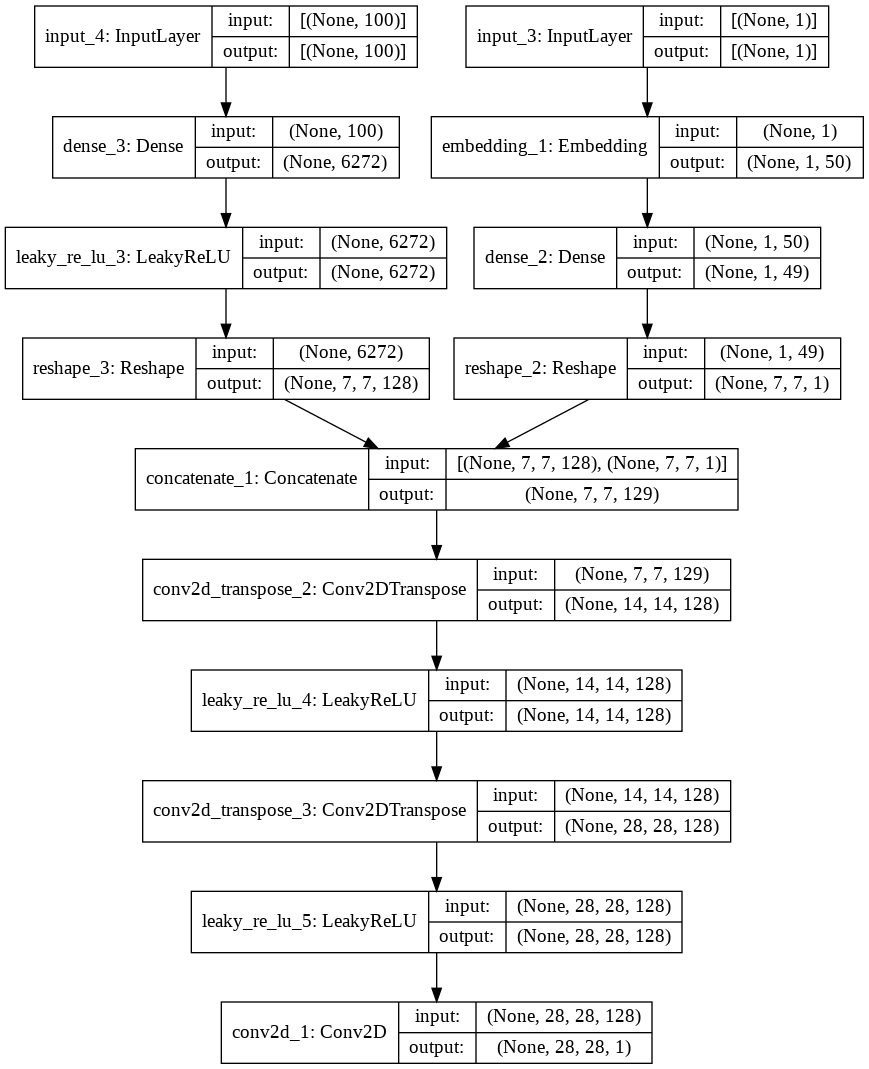

In [18]:
n_classes = 10
generator = make_generator_model(n_classes)
tf.keras.utils.plot_model(generator, show_shapes=True, to_file='generator.png')

Example of an initialization random images. The process will convert this into an image the `discriminator` won't be able to tell the difference to a real one.

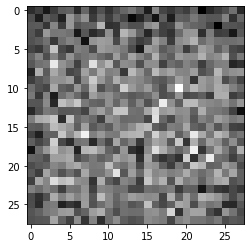

In [19]:
#generator.summary()
noise = tf.random.normal([1, 100])
from numpy.random import randint
noisy_label = randint(0, n_classes, 1)
generated_image = generator([noise, noisy_label], training=False)
plt.imshow((generated_image[0, :, :, 0] + 1) / 2, cmap='gray_r')

### The Discriminator

The discriminator is a CNN-based image classifier.

The second channel in the output of the `Concatenate`, is the `Embedding` of the image class or label input.

After the `Concatenate`, this is a regular Convolutional Neural Network, to achieve the classification between Real and Fake.

In [20]:
#make our own discriminator model
def make_discriminator_model(n_classes, in_shape=(28,28,1)):

  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)

  # image input
  in_image = Input(shape=in_shape)

  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation=None)(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

  return model

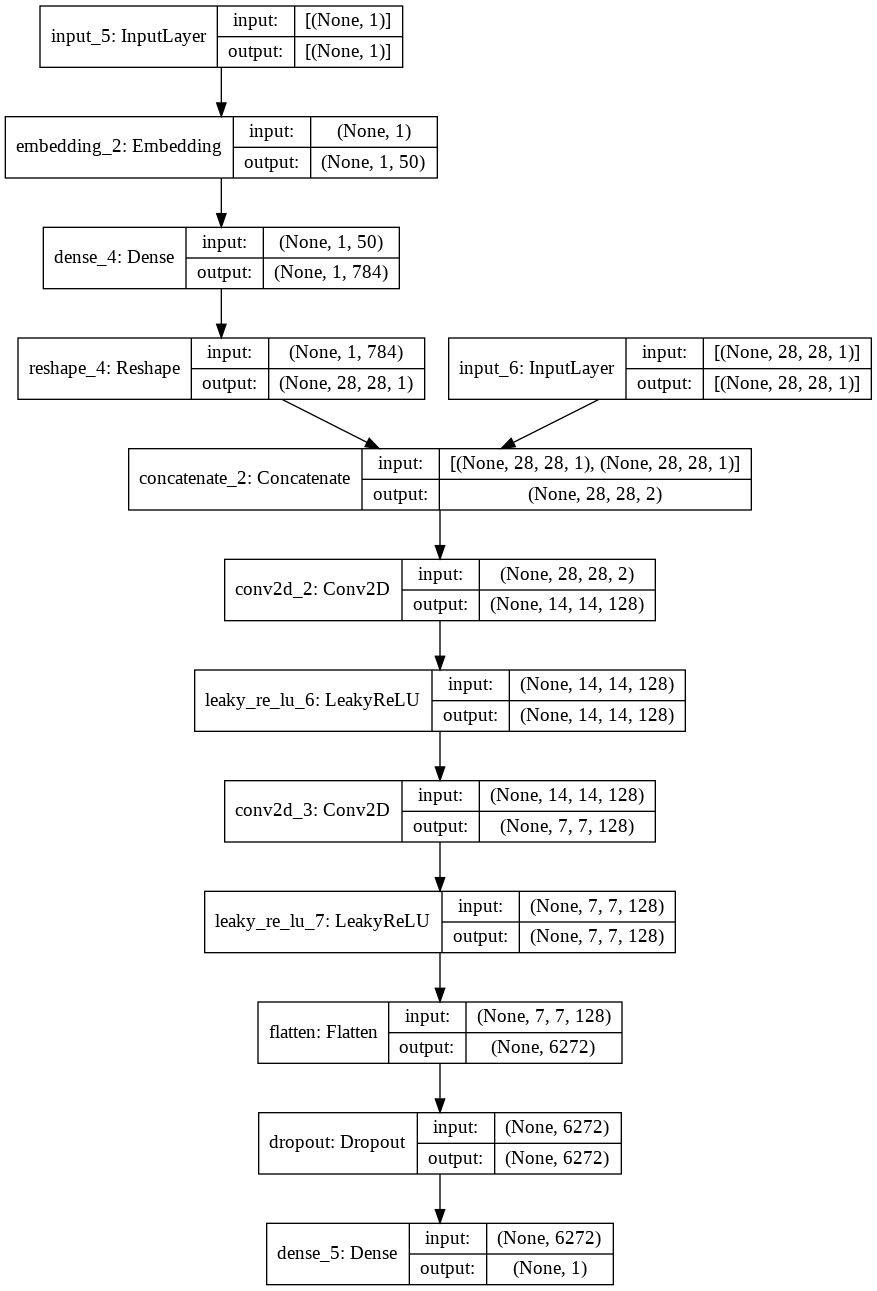

In [21]:
n_classes = 10
discriminator = make_discriminator_model(n_classes)
tf.keras.utils.plot_model(discriminator, show_shapes=True, to_file='discriminator.png')

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

Following is an example

In [26]:
#discriminator.summary()
from numpy.random import randint
label = randint(0, n_classes, 1)
print(f"Label: {label}")
decision = discriminator([generated_image, label])
print (f"Decision after the discriminator: {decision[0]} (0 and close, means 'fake')")

Label: [1]
Decision after the discriminator: [-0.00278823] (low number close to 0, means 'fake')


## Define the loss and optimizers

Define loss functions and optimizers for both models.

A few considerations:
* The images are normalized to cell values between [-1 to 1] at the function `format_example`.
* The function `make_discriminator_model` has `None` defined as activation in the output layer.
* The following loss function [`BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryCrossentropy), has defined `from_logits=True`, so no conversion.

This last, means the input values to the function are not probabilities, and will not be converted using [`Logit`](https://en.wikipedia.org/wiki/Logit) to the original value (`Logit` is the inverse of the `sigmoidal function`).

In Keras, the expectation is that the first input parameter of `binary_crossentropy` represent probabilities and are therefore bounded by [0 1]. So, they need to be converted back to raw values before being fed into [`tf.nn.sigmoid_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Again, we first run numbers through one function ([`sigmoid`](https://en.wikipedia.org/wiki/Sigmoid_function)), only to convert them back using the inverse function ([`logit`](https://en.wikipedia.org/wiki/Logit)).

But Keras’s `binary_crossentropy`, when fed with input resulting from `sigmoid` activation, will not produce over- or underflow of numbers.

More at [towardsdatascience](https://towardsdatascience.com/sigmoid-activation-and-binary-crossentropy-a-less-than-perfect-match-b801e130e310).

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
metricsAcc=tf.keras.metrics.BinaryAccuracy()

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In this training example, we are feeding the generator with 0 to 9 labels. And will generate 100 images.

In [ ]:
noise_dim = 100
num_examples_to_generate = 100

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
from numpy import asarray
seed_images = tf.random.normal([num_examples_to_generate, noise_dim])
seed_labels = asarray([x for _ in range(10) for x in range(10)])
print(seed_labels)

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

Using [`GradientTape`](https://www.tensorflow.org/guide/autodiff#gradient_tapes), to compute the gradients of an already "recorded" computation using reverse mode differentiation.

Some neural network layers behave differently during training and inference, for example `Dropout` and `BatchNormalization` layers. 
* During training, dropout will randomly drop out units and correspondingly scale up activations of the remaining units.
* During inference, it does nothing (since you usually don't want the randomness of dropping out units here).

Source: [StackOverFlow](https://stackoverflow.com/a/57322080/3780957)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
    # Generates the noise image pixels
    noise_image = tf.random.normal([BATCH_SIZE, noise_dim])
    # Generates the noise image label
    noise_labels = randint(0, n_classes, BATCH_SIZE)
    #print("coming into the function")

    # Computing gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      real_output = discriminator([images, labels], training=True)
      #print("salida con imagenes reales {:.5f}".format(tf.math.reduce_mean(real_output)))
      # Generates the fake image, according the provided `noise_label`
      generated_images = generator([noise_image, noise_labels], training=True)
      # Discriminates if the image is real or fake
      fake_output = discriminator([generated_images, noise_labels], training=True)
      #print("salida con imagenes falsas {:.5f}".format(tf.math.reduce_mean(fake_output)))
      
      # Calculate the noise for the `generator` and the `discriminator`
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    # "gradient" method returns a list, one for each element in sources. In this case it's the loss and the variable 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # `apply_gradients` method processes aggregated gradients.  
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Definition of a training process.

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    # Train the network on each image. This is changeing the weights and parammeters in the network 
    for image_batch, label_batch in dataset:
      train_step(image_batch, label_batch)

    print("A NEW EPOCH")
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed_images, seed_labels)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  # Store the GIF image in the drive (if using Colab, will be stored in the Files) 
  generate_and_save_images(generator, epochs, seed_images, seed_labels)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input_images, test_input_labels):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # This was explained and referenced before.
  predictions = model([test_input_images, test_input_labels], training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 10, i+1)
      # scale [-1, 1] to [0, 1]
      image = (predictions[i, :, :, 0] + 1.0) / 2.0
      #Gray Reverse, to have a white background
      plt.imshow(image, cmap='gray_r')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 100 epochs, they resemble `Fashion MNIST` object or item.

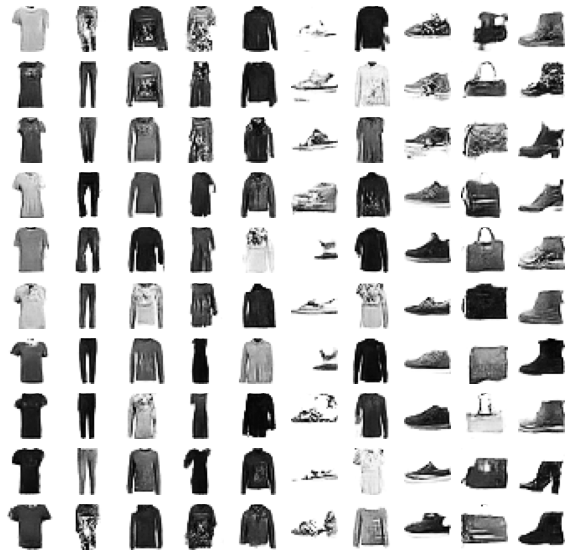

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 100
# Generates the labeled training dataset 
train_dataset_shuffled = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# Executes the proper training process 
train(train_dataset_shuffled, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Display the last epoch of the training process.

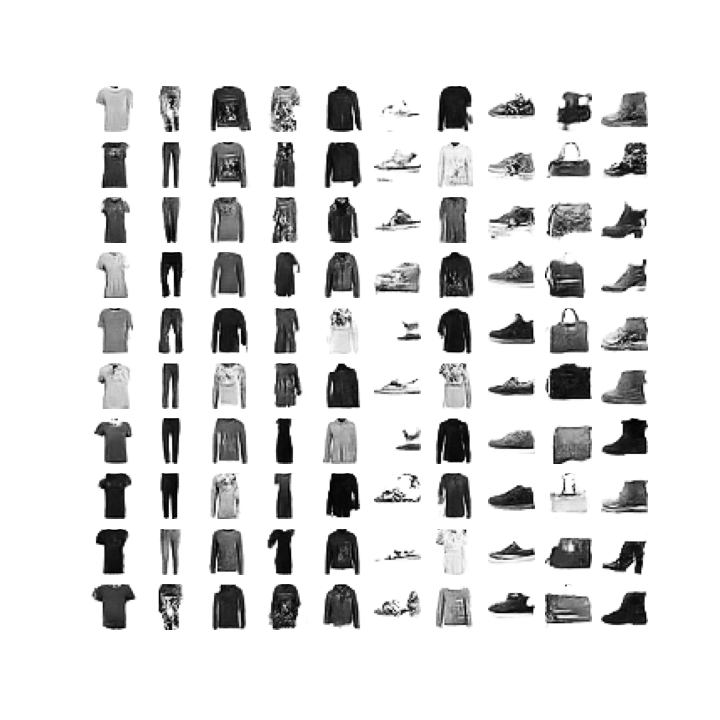

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>